In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths
train_csv_path = "/Users/ankitsanjyal/Desktop/Projects/Portfolio/AI-REAL-IMAGES-DATA/train.csv"  
train_images_path = "/Users/ankitsanjyal/Desktop/Projects/Portfolio/AI-REAL-IMAGES-DATA/"  

# Load train.csv
df_train = pd.read_csv(train_csv_path)

df_train["image_path"] = df_train["file_name"].apply(lambda x: os.path.join(train_images_path, x))
df_train.head()



,Unnamed: 0,file_name,label,image_path
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1,/Users/ankitsanjyal/Desktop/Projects/Portfolio...
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0,/Users/ankitsanjyal/Desktop/Projects/Portfolio...
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1,/Users/ankitsanjyal/Desktop/Projects/Portfolio...
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0,/Users/ankitsanjyal/Desktop/Projects/Portfolio...
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1,/Users/ankitsanjyal/Desktop/Projects/Portfolio...


Convert images into 256*256

Convert images into grayscale for intensity analysis

In [2]:

# Function to preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    if img is None:
        print(f"Error: Unable to read {image_path}")
        return None
    img_resized = cv2.resize(img, (256, 256))  # Resize to 256x256
    return img_resized

# Apply preprocessing to all images
df_train["processed_image"] = df_train["image_path"].apply(preprocess_image)

## Intensity based feature extraction

Analyse the pixel intensity distributions for AI and real images

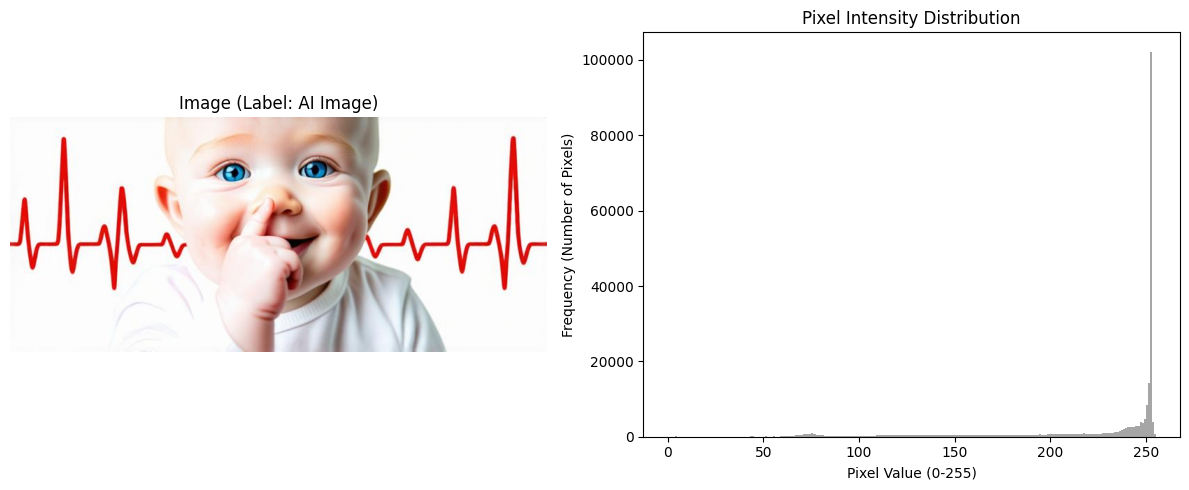

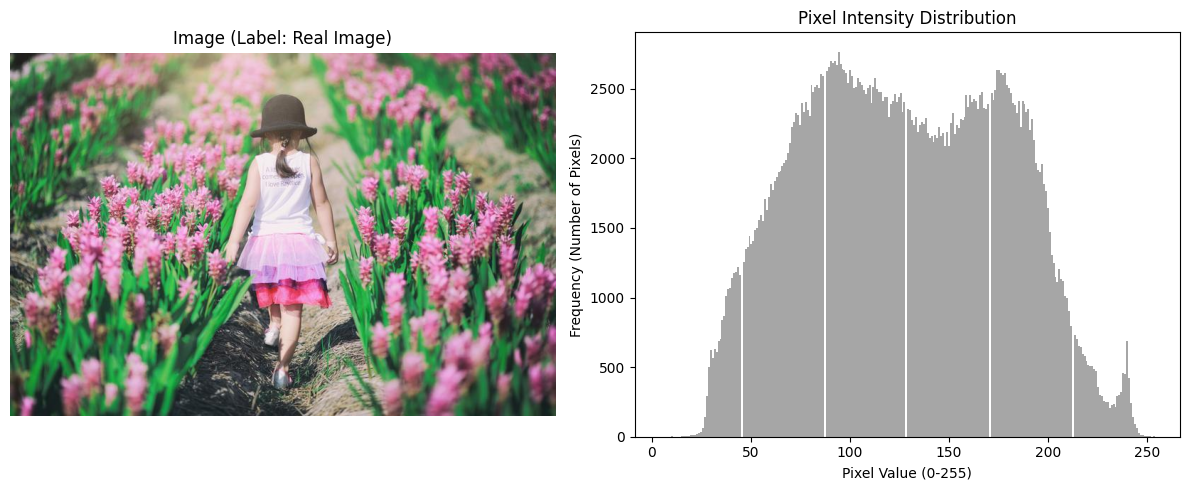

In [11]:
# Function to display image and its intensity distribution side by side
def plot_pixel_intensity(image_path, label):
    img = cv2.imread(image_path)  # Read in original color (BGR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for histogram

    # Create figure with 2 subplots (Image + Pixel Intensity Distribution)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Show Image
    axes[0].imshow(img_rgb)
    axes[0].axis("off")
    axes[0].set_title(f"Image (Label: {label})")

    # Plot Pixel Intensity Distribution
    axes[1].hist(img_gray.ravel(), bins=256, color="gray", alpha=0.7)
    axes[1].set_xlabel("Pixel Value (0-255)")
    axes[1].set_ylabel("Frequency (Number of Pixels)")
    axes[1].set_title("Pixel Intensity Distribution")
    
    plt.tight_layout()
    plt.show()

# Select a sample AI and real image
sample_ai = df_train[df_train["label"] == 1].sample(1)["image_path"].values[0]
sample_real = df_train[df_train["label"] == 0].sample(1)["image_path"].values[0]

# Plot intensity distributions
plot_pixel_intensity(sample_ai, "AI Image")
plot_pixel_intensity(sample_real, "Real Image")


We can see the progression of the pixel frequency in most of the real images but the spike in AI images

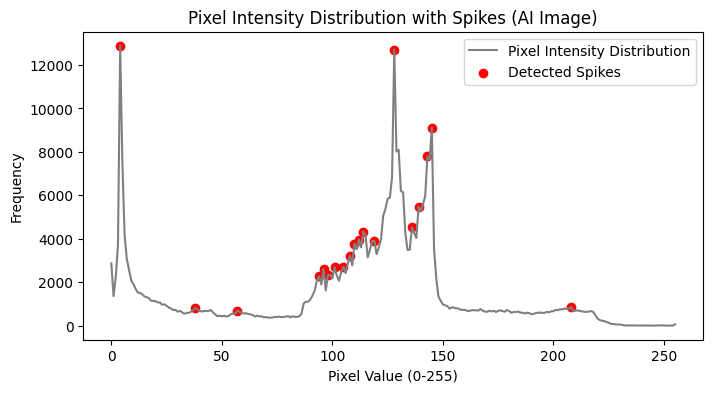

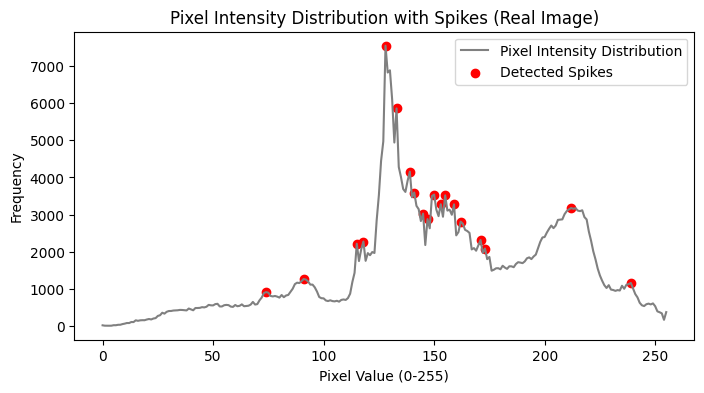

AI Image Spikes at: [  4  38  57  94  96  98 101 105 108 110 112 114 119 128 136 139 143 145
 208]
Real Image Spikes at: [ 74  91 115 118 128 133 139 141 145 147 150 153 155 159 162 171 173 212
 239]


In [20]:

from sklearn.metrics import accuracy_score

# Function to analyze intensity distribution
def detect_spikes(image_path, prominence_factor=0.2, width_factor=5):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    hist, _ = np.histogram(img.ravel(), bins=256, range=[0,256])  # Compute histogram
    
    # Detect peaks (large spikes)
    max_hist_value = max(hist)  # Get max frequency in histogram
    peaks, properties = find_peaks(hist, prominence=prominence_factor * max_hist_value, width=width_factor)
    
    return peaks, hist

# Define different spike thresholds for testing
spike_thresholds = [7000, 10000, 12000]

# Store results for each threshold
results = {}

for threshold in spike_thresholds:
    predicted_labels = []
    
    for _, row in df_train.iterrows():
        image_path = row["image_path"]
        true_label = row["label"]

        peaks, hist = detect_spikes(image_path)
        max_spike = max(hist[peaks]) if len(peaks) > 0 else 0  # Get max peak frequency

        # Rule-based classification: AI if max spike exceeds threshold
        predicted_label = 1 if max_spike >= threshold else 0
        predicted_labels.append(predicted_label)
    
    # Compute accuracy for this threshold
    accuracy = accuracy_score(df_train["label"], predicted_labels)
    results[threshold] = accuracy
    print(f"Threshold: {threshold} → Accuracy: {accuracy:.4f}")

# Display best threshold
best_threshold = max(results, key=results.get)
print(f"\n🔹 Best Spike Threshold: {best_threshold} with Accuracy: {results[best_threshold]:.4f}")


Threshold: 7000 → Accuracy: 0.4067
Threshold: 10000 → Accuracy: 0.4431
Threshold: 12000 → Accuracy: 0.4576

🔹 Best Spike Threshold: 12000 with Accuracy: 0.4576
